In [1]:
# Environnement de Kaggle qui permet de ne pas utiliser le cpu et la ram de notre machine et qui a deja plusieurs librairies pre-installés

import numpy as np 
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.utils import np_utils




import os
        
DIR_PATH = '/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'
CLASSES = ['COVID', 'NORMAL', 'Viral Pneumonia']

Using TensorFlow backend.


In [2]:
all_data = []
for dirname, _, filenames in os.walk(DIR_PATH): # os.walk retourne premierement le Path puis les directories sous le path puis tous les fichiers du path donc dirname ici sont covid,normal et vp et filenames sont les images sous chaque dirname.
    for file in filenames:
        if 'png' in file:
            image = cv2.imread(os.path.join(dirname, file))
            image = cv2.resize(image, (64, 64)) / 255.0 # we resize the image to 64 height and 64 width, we divide by 255 to obtain normalized values between 0 and 1(bcs pixels of the image are between 0 and 255), so that the optimizer doesnt explode and be efficient
            label = CLASSES.index(os.path.split(dirname)[-1]) # label sera 0 ou 1 ou 2 un int donc
            #print(os.path.split(dirname)[-1]) : retourne '/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database', 'NORMAL' en premier donc le -1 est pour prendre le dernier élément de ce retour qui est 'NORMAL'
            all_data.append([image, label])
            

In [3]:
len(all_data)

3886

In [4]:
X = []
y = []
for img, lbl in all_data:
    X.append(img)
    y.append(lbl)
X = np.array(X)
y = np.array(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
X_train.shape,X_test.shape

((2720, 64, 64, 3), (1166, 64, 64, 3))

## First model

In [7]:
# input shape de l'image (64,64,3) :(width,height,RGB channels),on a le 3 car images couleurs
model_1 = models.Sequential() # Le model est sequentiel c'est a dire les données rentrent batch par batch sequence par sequence 
    
model_1.add(layers.Conv2D(30, (5, 5), input_shape=(64, 64, 3), activation='relu')) # Relu fonction linéaire donc elle permet de converger plus rapidement,on sélectionne 30 features de l'image,notamment détection des edges avec une matrice 5*5(filtrage)
model_1.add(layers.MaxPooling2D(pool_size=(2, 2))) # Reduction de la dimension de l'image par le biais d'une matrice 2*2 où on garde le max
    
model_1.add(layers.Conv2D(15, (3, 3), activation='relu')) # on sélectionne 15 features de l'image,avec une matrice 3*3 (filtrage)
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
model_1.add(layers.Dropout(0.2)) # on perd 20% des neurones du réseau afin d'éviter un over-fitting.
model_1.add(layers.Flatten()) # transforme en image qui a une shape à 3 dimensions en un vecteur 1 dimension
    
model_1.add(layers.Dense(128, activation='relu')) # couche avec 128 neuronnes
model_1.add(layers.Dense(50, activation='relu')) # couche avec 50 neuronnes
model_1.add(layers.Dense(3, activation='softmax')) # on utilise la fonction softmax car elle permet d'avoir des valeurs en output entre [0,1] ce qui permet une classification avec n'importe quel nbr de classes ici on en a plus que 2 (cas non binaires)
    
# Compile model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
#Adam optimizer pour optimiser nos poids ,SparseCategoricalCrossentropyloss function when there are two or more label classes. We expect labels to be provided as integers, which is our case here.

In [8]:
history_1 = model_1.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test),batch_size=50)

Train on 2720 samples, validate on 1166 samples
Epoch 1/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.8242 - accuracy: 0.7320 - val_loss: 0.6667 - val_accuracy: 0.8937
Epoch 2/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.6735 - accuracy: 0.8849 - val_loss: 0.6495 - val_accuracy: 0.9074
Epoch 3/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.6448 - accuracy: 0.9151 - val_loss: 0.6500 - val_accuracy: 0.9031
Epoch 4/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.6402 - accuracy: 0.9151 - val_loss: 0.6203 - val_accuracy: 0.9322
Epoch 5/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.6292 - accuracy: 0.9224 - val_loss: 0.6368 - val_accuracy: 0.9168
Epoch 6/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.6303 - accuracy: 0.9199 - val_loss: 0.6154 - val_accuracy: 0.9365
Epoch 7/30
2720/2720 [==============================] - 8s 3ms/sample - loss

In [9]:
scores_1 = model_1.evaluate(X_test, y_test, verbose=0)
print('Final CNN accuracy of model 1: ', scores_1[1]*100, "%")

Final CNN accuracy of model 1:  95.28301954269409 %


## Second model

In [10]:
#Initializing the CNN
#There is also a graph option but we'll use sequential ANN Model
model_2 = models.Sequential()

#step 1 - Convolution
#creating the feature map by using feature detector from ınput image

model_2.add(layers.Convolution2D(32,3,3, input_shape=(64,64,3), activation='relu'))
#32 Feature maps&detetctors uses 3 by 3 matrices, we can put 128 in the powerful machines

#step -2 Pooling
model_2.add(layers.MaxPooling2D(pool_size = (2,2)))

#second convolution and pooling steps.
model_2.add(layers.Convolution2D(32,3,3, input_shape=(64,64,3), activation='relu'))

model_2.add(layers.MaxPooling2D(pool_size = (2,2)))

#step -3 Flattening
model_2.add(layers.Flatten())

#step-4 Full connection step
model_2.add(layers.Dense(64, activation = 'relu'))
model_2.add(layers.Dense(3, activation = 'softmax'))


model_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])


In [11]:
history_2 = model_2.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test),batch_size=50)

Train on 2720 samples, validate on 1166 samples
Epoch 1/30
2720/2720 [==============================] - 1s 468us/sample - loss: 1.0609 - accuracy: 0.5059 - val_loss: 0.9606 - val_accuracy: 0.7238
Epoch 2/30
2720/2720 [==============================] - 1s 315us/sample - loss: 0.8815 - accuracy: 0.7250 - val_loss: 0.8213 - val_accuracy: 0.7993
Epoch 3/30
2720/2720 [==============================] - 1s 324us/sample - loss: 0.7888 - accuracy: 0.7982 - val_loss: 0.7391 - val_accuracy: 0.8448
Epoch 4/30
2720/2720 [==============================] - 1s 335us/sample - loss: 0.7376 - accuracy: 0.8338 - val_loss: 0.6978 - val_accuracy: 0.8868
Epoch 5/30
2720/2720 [==============================] - 1s 388us/sample - loss: 0.7191 - accuracy: 0.8449 - val_loss: 0.6986 - val_accuracy: 0.8688
Epoch 6/30
2720/2720 [==============================] - 1s 335us/sample - loss: 0.7059 - accuracy: 0.8515 - val_loss: 0.6951 - val_accuracy: 0.8645
Epoch 7/30
2720/2720 [==============================] - 1s 325us

In [12]:
scores_2 = model_2.evaluate(X_test, y_test, verbose=0)
print('Final CNN accuracy of model 2: ', scores_2[1]*100, "%")

Final CNN accuracy of model 2:  90.73756337165833 %


## First model with sgd

In [13]:
# input shape de l'image (64,64,3) :(width,height,RGB channels),on a le 3 car images couleurs
model_1_sgd = models.Sequential()
    
model_1_sgd.add(layers.Conv2D(30, (5, 5), input_shape=(64, 64, 3), activation='relu')) # Relu fonction linéaire donc elle permet de converger plus rapidement,on sélectionne 30 features de l'image,notamment détection des edges avec une matrice 5*5(filtrage)
model_1_sgd.add(layers.MaxPooling2D(pool_size=(2, 2))) # Reduction de la dimension de l'image par le biais d'une matrice 2*2 où on garde le max
    
model_1_sgd.add(layers.Conv2D(15, (3, 3), activation='relu')) # on sélectionne 15 features de l'image,avec une matrice 3*3 (filtrage)
model_1_sgd.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
model_1_sgd.add(layers.Dropout(0.2)) # on perd 20% des neurones du réseau afin d'éviter un over-fitting.
model_1_sgd.add(layers.Flatten()) # transforme en image qui a une shape à 3 dimensions en un vecteur 1 dimension
    
model_1_sgd.add(layers.Dense(128, activation='relu')) # couche avec 128 neuronnes
model_1_sgd.add(layers.Dense(50, activation='relu')) # couche avec 50 neuronnes
model_1_sgd.add(layers.Dense(3, activation='softmax')) # on utilise la fonction softmax car elle permet d'avoir des valeurs en output entre [0,1] ce qui permet une classification avec n'importe quel nbr de classes ici on en a plus que 2 (cas non binaires)
    

model_1_sgd.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='sgd', metrics=['accuracy'])

In [14]:
history_1_sgd = model_1_sgd.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_test, y_test),batch_size=50)

Train on 2720 samples, validate on 1166 samples
Epoch 1/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 1.0920 - accuracy: 0.3614 - val_loss: 1.0884 - val_accuracy: 0.3199
Epoch 2/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 1.0816 - accuracy: 0.3827 - val_loss: 1.0720 - val_accuracy: 0.3285
Epoch 3/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 1.0549 - accuracy: 0.5151 - val_loss: 1.0138 - val_accuracy: 0.6201
Epoch 4/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.9774 - accuracy: 0.6658 - val_loss: 0.8893 - val_accuracy: 0.8113
Epoch 5/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.8844 - accuracy: 0.6960 - val_loss: 0.7994 - val_accuracy: 0.8216
Epoch 6/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.8419 - accuracy: 0.7235 - val_loss: 0.7773 - val_accuracy: 0.7804
Epoch 7/30
2720/2720 [==============================] - 8s 3ms/sample - loss

In [15]:
scores_1_sgd = model_1_sgd.evaluate(X_test, y_test, verbose=0)
print('Final CNN accuracy of model 1 with sgd: ', scores_1_sgd[1]*100, "%")

Final CNN accuracy of model 1 with sgd:  90.65179824829102 %


 ## We plot the loss and accuracy of our first model over 30 epochs

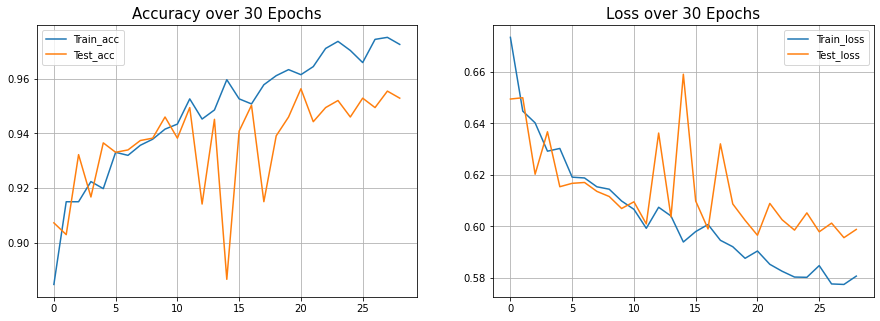

In [16]:
def plot_acc_loss(results, epochs):
 acc = results.history['accuracy']
 loss = results.history['loss']
 val_acc = results.history['val_accuracy']
 val_loss = results.history['val_loss']
 plt.figure(figsize=(15, 5))
 plt.subplot(121)
 plt.plot( acc[1:], label='Train_acc')
 plt.plot( val_acc[1:], label='Test_acc')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.subplot(122)
 plt.plot( loss[1:], label='Train_loss')
 plt.plot( val_loss[1:], label='Test_loss')
 plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
 plt.legend()
 plt.grid(True)
 plt.show()
 
plot_acc_loss(history_1, 30)

## We plot the loss and accuracy of our second model over 30 epochs

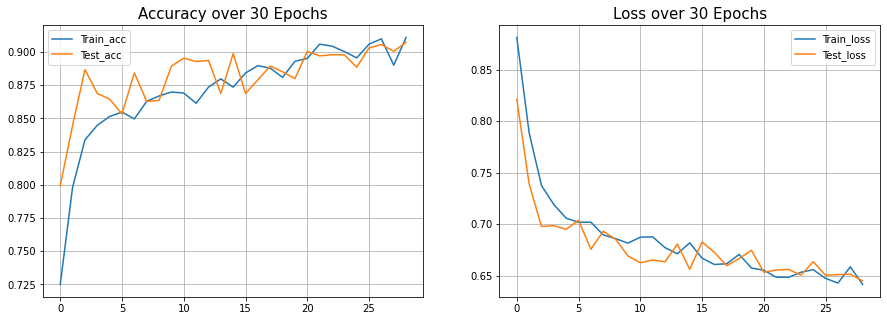

In [17]:
plot_acc_loss(history_2, 30)

## We plot the loss and accuracy of our first model this time with sgd as optimizer over 30 epochs.

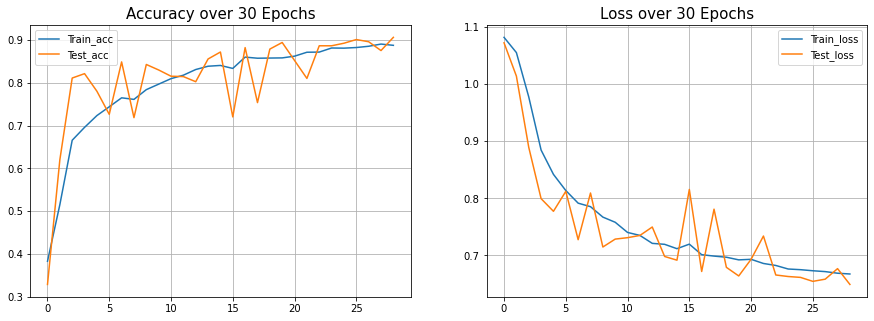

In [18]:
plot_acc_loss(history_1_sgd, 30)

## This time we will hot-encode our output to use a different loss function with our first model

## Before we had labels as integers : 0 : covid , 1 : normal and 2 : viral pneumonia for example , now our labels will be vectors: (1,0,0) for example for covid. This will give us the possibility to use a different loss function and see the difference between having and int as outpout and a vector. Because sometimes using integers as output can give higher weights to the category with the higher number and this could mess with our model.

In [19]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)


In [20]:
# input shape de l'image (64,64,3) :(width,height,RGB channels),on a le 3 car images couleurs
model_1_encode = models.Sequential()
    
model_1_encode.add(layers.Conv2D(30, (5, 5), input_shape=(64, 64, 3), activation='relu',)) # Relu fonction linéaire donc elle permet de converger plus rapidement,on sélectionne 30 features de l'image,notamment détection des edges avec une matrice 5*5(filtrage)
model_1_encode.add(layers.MaxPooling2D(pool_size=(2, 2))) # Reduction de la dimension de l'image par le biais d'une matrice 2*2 où on garde le max
    
model_1_encode.add(layers.Conv2D(15, (3, 3), activation='relu')) # on sélectionne 15 features de l'image,avec une matrice 3*3 (filtrage)
model_1_encode.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
model_1_encode.add(layers.Dropout(0.2)) # on perd 20% des neurones du réseau afin d'éviter un over-fitting.
model_1_encode.add(layers.Flatten()) # transforme en image qui a une shape à 3 dimensions en un vecteur 1 dimension
    
model_1_encode.add(layers.Dense(128, activation='relu')) # couche avec 128 neuronnes
model_1_encode.add(layers.Dense(50, activation='relu')) # couche avec 50 neuronnes
model_1_encode.add(layers.Dense(3, activation='softmax')) # on utilise la fonction softmax car elle permet d'avoir des valeurs en output entre [0,1] ce qui permet une classification avec n'importe quel nbr de classes ici on en a plus que 2 (cas non binaires)
    
# Compile model
model_1_encode.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Adam optimizer pour optimiser nos poids ,CategoricalCrossentropyloss function when there are two or more label classes. We expect labels to be provided as vectors.

In [21]:
history_1_encode = model_1_encode.fit(X_train, y_train_cnn, epochs=30, 
                    validation_data=(X_test, y_test_cnn))

Train on 2720 samples, validate on 1166 samples
Epoch 1/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.7598 - accuracy: 0.6316 - val_loss: 0.3545 - val_accuracy: 0.8808
Epoch 2/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.2695 - accuracy: 0.8960 - val_loss: 0.2379 - val_accuracy: 0.9211
Epoch 3/30
2720/2720 [==============================] - 8s 3ms/sample - loss: 0.2385 - accuracy: 0.9125 - val_loss: 0.2092 - val_accuracy: 0.9314
Epoch 4/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.2243 - accuracy: 0.9195 - val_loss: 0.2147 - val_accuracy: 0.9322
Epoch 5/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.1799 - accuracy: 0.9327 - val_loss: 0.2365 - val_accuracy: 0.9160
Epoch 6/30
2720/2720 [==============================] - 9s 3ms/sample - loss: 0.1590 - accuracy: 0.9412 - val_loss: 0.1763 - val_accuracy: 0.9425
Epoch 7/30
2720/2720 [==============================] - 8s 3ms/sample - loss

In [22]:
scores_1_encode = model_1_encode.evaluate(X_test, y_test_cnn, verbose=0)
print('Final CNN accuracy of model 1 with hot encoding: ', scores_1_encode[1]*100, "%")

Final CNN accuracy of model 1 with hot encoding:  96.05488777160645 %


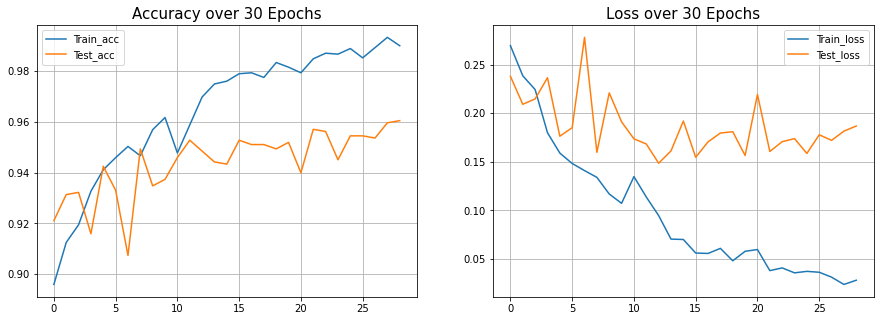

In [23]:
plot_acc_loss(history_1_encode, 30)

## Some predictions with external data

## First model with sgd optimizer

In [24]:
from keras.preprocessing import image
test_image = image.load_img('/kaggle/input/test-cnn-covid/Covid19.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image) # converts image to array
test_image = np.expand_dims(test_image, axis = 0) # adds dimension because convolutional layer expects 4 dimensions (the added dimension is the batch size dimension to feed N number of data points at time to the model)
output = model_1_sgd.predict(test_image) # return vector with 1 for the prediction and 0 for the rest
print("Predicted:", CLASSES[np.argmax(output)]) # max so that it takes the one which is the prediction and returns the name of the predicted class

Predicted: COVID


In [25]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/covid19_2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1_sgd.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [26]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1_sgd.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: NORMAL


In [27]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/vp2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1_sgd.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


## Second model

In [28]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/Covid19.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [29]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/covid19_2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [30]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: NORMAL


In [31]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy2.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [32]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy4.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [33]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/vp2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_2.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


## First model with adam optimizer

In [34]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/Covid19.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [35]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/covid19_2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [36]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [37]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/vp2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


## Firs model with one hot encoding

In [38]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/Covid19.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1_encode.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [39]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/healthy.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
output = model_1_encode.predict(test_image)
print("Predicted:", CLASSES[np.argmax(output)])

Predicted: COVID


In [40]:
test_image = image.load_img('/kaggle/input/test-cnn-covid/vp2.jpeg', target_size = (64, 64))
test_image = image.img_to_array(test_image) 
test_image = np.expand_dims(test_image, axis = 0) 
output = model_1_encode.predict(test_image) 
print("Predicted:", CLASSES[np.argmax(output)]) 

Predicted: COVID
